In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.8.0+cu126
2.8.0+cu126
cuda


In [2]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset


SPEECH_FILE = "Anne Marie - 2002(FULL) - YumiRean - SoundLoadMate.com.mp3"

In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [4]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [5]:
IPython.display.Audio(SPEECH_FILE)

In [6]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

C:\Users\박상인\AppData\Roaming\Python\Python313\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
C:\Users\박상인\AppData\Roaming\Python\Python313\site-packages\torchaudio\_backend\ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues

In [7]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

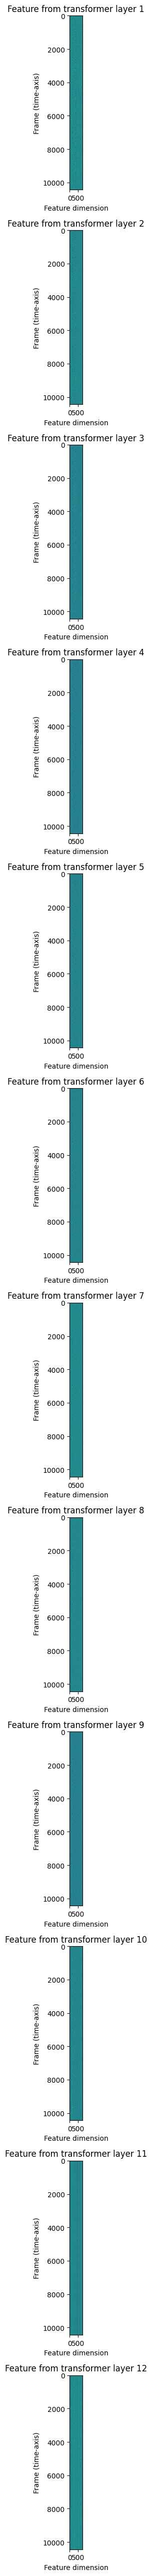

In [8]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [9]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


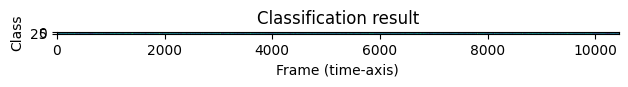

In [10]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [11]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [12]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [13]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

ILS|REMEMBER|MER|THEDAYU|ISMYALA|LIHE|O|FEND|MERANDOEN|JUST|LIKE|THE|LOW|NOE|BE|BED|THE|ASAMMER|SOS|L|N|MEMER|MMR|BER|WE|WALY|LEBR|MR|BUTANSILIKE|O|A|LIKWE|N|E|FRES|ER|JE|GAE|ONASTING|O|SIN|L|RAR|AND|NEMBER|NE|LAGATA|WAS|TOMR|MER|IMER|DANCIN|ON|LODIN|A|I|LOS|AOA|TAWOIS|SAYSO|IT||S|OFRIENDS|AND|I|WA|LIKE|TO|SA|O|||DAN|NALA|O|SING|A|A|A|BA|OD|O|WE||GO|A|G|W|BATE|BE|BEONS||O|AY||TAT|SH|WE||WE|A|TADESS|O|WE|WE|A|SA|||A|TAA|A|B|O|NW|WE|L|A|A|O|THE|O|A|MER|FIS|FOA|SO|A|SEWE|AR|A|A|LOVS|ME||YER|WE||WEE|WADANY|ATER|ON|YKIN|BA|I|O|LA|AN|TOME|ME||||GAR|DANCIN|ON|OEIA|WI|LS|AOMA|STAWEOE|SAYSO|IT||S|O|FRIEND|AN|A|WA|IKE|TO|SAY||A|DAN|NE|A|O|SENG|A|BA|BA|BA|OD|O|WE||GO|A|GA|BA||E|BE|BE|OS||O|AY|A|TAT|SO|WE|A|WE||A|DSS|O|WE|WE|A|SIN|WE|||T|AA|NE|DA|I|BAA|L|N|A|OE|DAY|WI|AI|LAN|DANCIN||IK|IN|A|MI|LITL|AS|MO|TAWAE|S|SO|E|A|OA|O|FRIENDS|ALO|AA|NON|ALO|OSNNI|ABA|DAY|IF|YOU|ANT|A|GO|AGA|EE|BT|I||BEE|ONS|O|AAA|TAT|O|WE||WE|A|TA|DESS||WE|WE|O|SE|E|A|A|AABAAO|ONE|DAY|WITA|LA|||A|N|N|WE|AN||O||A||OE|DA|WI|AN

In [14]:
model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
emission = model(waveforms, ...)

NameError: name 'waveforms' is not defined